In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [21]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
df = pd.read_csv(url)

df.drop(columns=['name'], inplace=True)

X = df.drop(columns=['status'])
y = df['status']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rfe_selector = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=10)
X_selected = rfe_selector.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
selected_features = df.drop(columns=["name", "status"]).columns[rfe_selector.support_]
print("Top 10 Features:", selected_features.tolist())

In [22]:
results = {}
conf_matrices = {}
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'IsolationForest': IsolationForest(contamination=0.1, random_state=42)
    
}

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)


In [24]:
def store_results(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    conf_matrices[name] = confusion_matrix(y_test, y_pred)


In [25]:

# Function to store results for Isolation Forest (Unsupervised)
def store_isolation_results(name, iso_model, X_test, y_test):
    y_pred = iso_model.predict(X_test)
    y_pred = np.where(y_pred == -1, 1, 0)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": None  # Not applicable for unsupervised
    }
    conf_matrices[name] = confusion_matrix(y_test, y_pred)


In [26]:
results = {}
conf_matrices = {}
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Model evaluation loop
for name, model in models.items():
    if name == 'IsolationForest':
        model.fit(X_train)  # Fit Isolation Forest (unsupervised)
        store_isolation_results(name, model, X_test, y_test)
    else:
        if name == 'RandomForest':  # Apply grid search for RandomForest
            grid_search.fit(X_res, y_res)
            best_rf = grid_search.best_estimator_
            best_rf.fit(X_res, y_res)
            store_results(name, best_rf, X_test, y_test)
        else:
            model.fit(X_res, y_res)
            store_results(name, model, X_test, y_test)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [27]:
#display results
results_df = pd.DataFrame(results).T
results_df['Model'] = results_df.index
results_df.reset_index(drop=True, inplace=True)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]
print(results_df)

              Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0      RandomForest  0.897436   0.962963  0.896552  0.928571  0.979310
1          AdaBoost  0.871795   0.961538  0.862069  0.909091  0.937931
2  GradientBoosting  0.923077   0.964286  0.931034  0.947368  0.968966
3           XGBoost  0.923077   0.964286  0.931034  0.947368  0.979310
4   IsolationForest  0.256410   0.500000  0.068966  0.121212       NaN


<Figure size 1200x600 with 0 Axes>

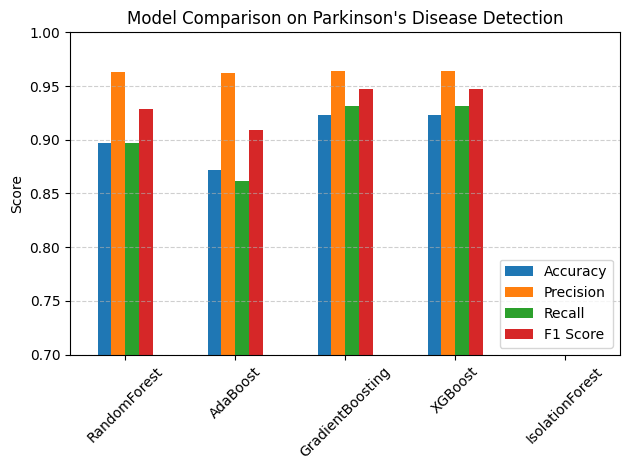

In [28]:
results_df = pd.DataFrame(results).T.drop(columns=["ROC AUC"]).round(3)
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar')
plt.title("Model Comparison on Parkinson's Disease Detection")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

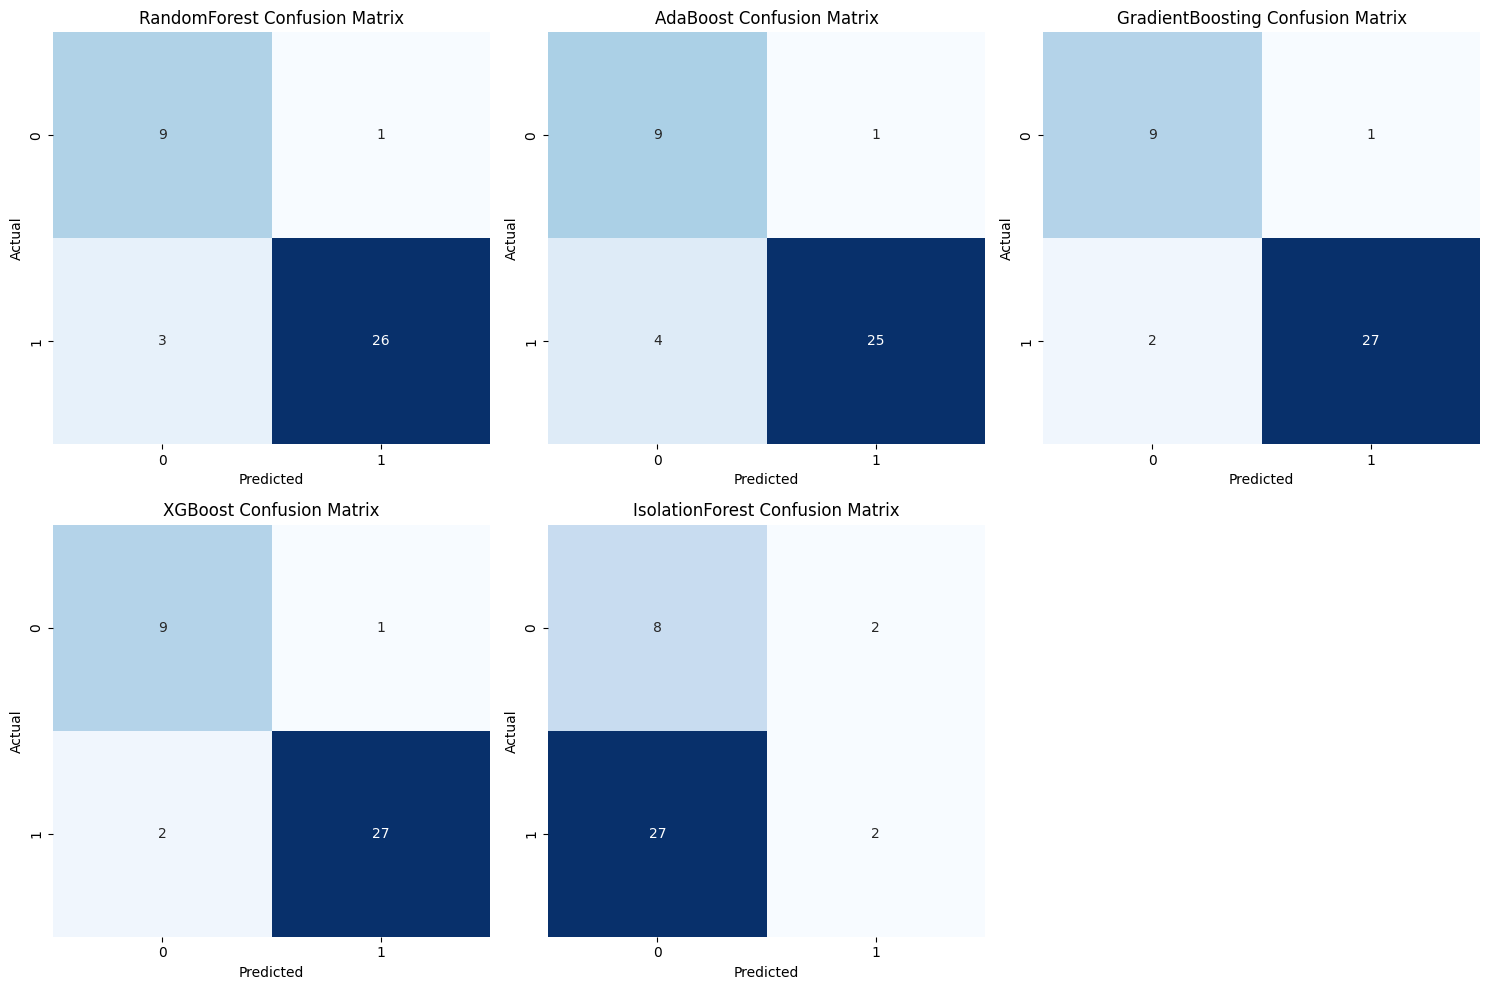

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Hide extra axes if any
for i in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

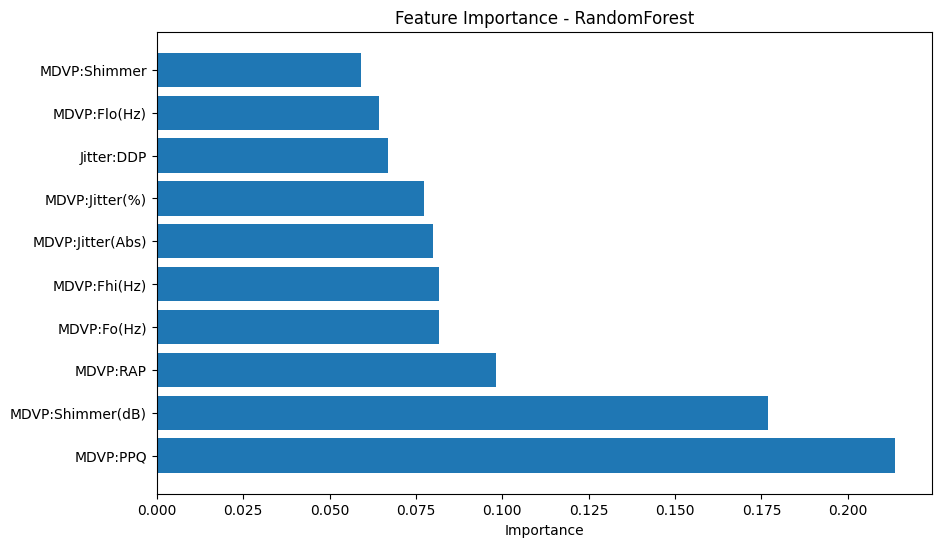

In [30]:
best_rf_model = grid_search.best_estimator_  # Get the best RandomForest model
feature_importance = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx])
plt.title("Feature Importance - RandomForest")
plt.xlabel("Importance")
plt.show()